In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

In [ ]:
keras.__version__

In [ ]:
tf.config.list_physical_devices()

# Datos: Clasificacion de ropa (Fashion_MNIST)

Asi como sklearn trae utilidades para cargar datasets estandar, keras también trae. En general, keras puede aceptar datasets en forma de Numpy Arrays (como sklearn), pero también trae una clase Dataset que esta optimizada para cargar datos (incluso si son mas grandes que la memoria RAM del equipo).

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

En Datasets grandes, CrossValidation puede ser muy costoso, por lo cual se recomienda separar un conjunton de validación aparte del training. Esto hacemos a continuación.

También normalizamos los píxeles (que van de 0 a 255) para que estén entre 0 y 1.

In [3]:
#Separo en entrenamiento y validacion, y normalizo los pixeles
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [ ]:
print(X_train_full.shape)

plt.imshow(X_train[0], cmap='binary', interpolation='bicubic')

Los targets son numericos, del 0 al 9. Podemos guardar las etiquetas asi nos es mas facil analizar que tan bien o mal funciona nuestro modelo:

In [ ]:
class_names = ["Remera/top", "Pantalones", "Pullover", "Vestido", "Abrigo",
               "Sandalias", "Camisa", "Zapatillas", "Bolso", "Bota"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Definir un modelo

Hay tres formas de definir modelos:
* Una es utilizando la clase de ``keras.models.Sequential``, que es apta para modelos donde solamente Layers adyacentes se encuentran conectados entre sí. 
* Otra es API funcional, que provee mucha mas flexibilidad, ya que se puede construir cualquier clase de red dirigida acíclica. 
* La ultima forma, es con SubClassing, es decir definiendo nuestras propias clases que hereden de las definidas en Keras, lo cual nos permite extender Keras para nuestras necesidades específicas, aunque no es recomendable a menos que realmente sepamos lo que estamos haciendo.

Si bien ahora quizás les sea mas sencillo utilizar la API secuencial, aprender a utilizar la API funcional es casi igual de fácil y provee mas flexibilidad, asi que es la forma que recomiendo de aprender a usar.

## API Secuencial

### Modo 1

Podemos crear un modelo, e ir añadiendo Layers sobre la marcha.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Creo un modelo secuencial
model = keras.models.Sequential()
#Y le voy agregando layers
model.add(keras.layers.Flatten(input_shape=[28, 28])) #matriz->vector (como np.ravel)
model.add(keras.layers.Dense(300, activation="relu")) #hidden 1
model.add(keras.layers.Dense(100, activation="relu")) #hidden 2
model.add(keras.layers.Dense(10, activation="softmax")) #output

### Modo 2

También podemos directamente pasar la lista de Layers al constructor del Modelo ``Sequential``.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Sino directamente le paso una lista al crearlo:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

## API Funcional

La API funcional funciona definiendo Layers y utilizandolo como si fueran "funciones" que se aplican a los outputs de otros Layers. Keras irá rastreando estas conecciones, y luego generará un modelo entre el Layer de Inputs, y el de Outputs.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_ = keras.layers.Input(shape=[28, 28]) #En este caso es necesario definir el Layer de Inputs
flatten = keras.layers.Flatten()(input_)
hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(10, activation="softmax")(hidden2)
model = keras.models.Model(inputs=[input_], outputs=[output])

# Compilar y visualizar

Una vez que hemos definido nuestro modelo, es necesario que lo "compilemos", entonces Keras creará el gráfico computacional en TensorFlow de acuerdo a como lo hemos definido.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Podemos acceder a los diferentes Layers, mediante el atributo ``.layers``

In [ ]:
model.layers

Y También podemos imprimir un resumen de nuestro modelo, asi como un lindo grafico de el:

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

Cada layer tiene atributos a los que podemos acceder, como el nombre, y métodos que nos devuelven, por ejemplo, los pesos.

Vemos que por default inicializa los pesos de forma aleatoria entre 0 y 1, y los bias a cero. Esto se puede cambiar pasando un ``initializer=``al compilar.

In [ ]:
hidden1 = model.layers[1]
print(hidden1.name)
weights, biases = hidden1.get_weights()
print(weights.shape)
print(weights[0], biases[0])


# Entrenar

Entrenar es tan facil como hacer un ``.fit``, donde podemos especificar muchas cosas como épocas, datos de validación (que evaluará al final de cada época), métricas, etc.

El método devuelve un objeto de Historia, con toda la información del entrenamiento (en forma de diccionarios), que podremos utilizar para analizar el modelo.

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Examinemos el diccionario de parámetros del fit:

In [ ]:
history.params

In [ ]:
history.history.keys()

Podemos usar el atributo "history" que nos da un diccionario, para plotear las métricas que usamos.

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluar y predecir

Evaluar en un conjunto de Test, o hacer predicciones, es sumamente fácil:

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

In [ ]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Guardar y Cargar Modelos

Guardar modelos es tan sencillo como hacer

In [ ]:
model.save("my_keras_model.h5")

Que luego se puede cargar (por ejemplo en otra computadora, con otro script, para hacer predicciones) usando:

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

También podemos guardar solamente los weights de los layers. Pero en este caso deberemos, antes de cargarlos, definir el mismo modelo que usamos y recien entonces cargar los weights

In [ ]:
model.save_weights("my_keras_weights.ckpt")

In [ ]:
model.load_weights("my_keras_weights.ckpt")

# Regresión: California Housing

Veamos como se desempeña para hacer regresión con el dataset de california housing que utilizamos en la guía de ejercicios Datasets. Importamos los datos, y los escaleamos usando StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

El modelo que definimos tiene como ultimo layer una funcion lineal, sin ninguna funcion de activación. (Es como hacer regresión lineal, pero fiteando unidades ReLu como funciones de base).

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
print(y_pred)

## Ventajas de la API funcional: Modelos no secuenciales

Aqui vemos un ejemplo de como podemos usar la API funcional para hacer modelos mas complejos. En el modelo [Wide and Deep](https://https://ai.google/research/pubs/pub45413) se conectan los inputs directamente a los outputs, ademas de pasando por una red profunda de dos capas. De esta manera, el modelo puede aprender features mas abstractos de los datos, y a la vez tomarlos directamente sin distorisión.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

In [ ]:
keras.utils.plot_model(model, "wide_and_deep_model.png", show_shapes=True)

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

# EXTRAS

Callbacks son una manera de hacer cosas durante el entrenamiento. Son utiles en caso que el modelo tarde mucho en fitear. Por ejemplo, podemos guardar el modelo al fin de cada epoca (por si se nos apaga la maquina en el medio del training), o implementar un regularizador EarlyStopping y dejar de fitear si el validation score no mejora, o enviarnos un mail cuando termine el entrenamiento con los resultados, etc.

## Callbacks: Guardar durante entrenamiento (checkpoints)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
 checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

 history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint_cb])

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.evaluate(X_valid,y_valid) 

## Callbacks: Early Stopping

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

## Busqueda de Hiperparámetros: Sklearn integration

Y lo mejor de todo, tiene un wrapper que nos permite integrarlo con ScikitLearn. Sklearn lo reconocerá el modelo como uno más de los suyos:

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [0]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [58]:
keras_reg.fit(X_train, y_train, epochs=30,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.1726 - val_loss: 2.5859
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6369 - val_loss: 1.3919
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5286 - val_loss: 1.1011
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4911 - val_loss: 1.0702
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4534 - val_loss: 0.5872
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4365 - val_loss: 0.7241
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4228 - val_loss: 0.5997
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4148 - val_loss: 0.9960
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4091 - val_loss: 0.8042
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4049 - val_loss: 1.5251

El modelo tiene los métodos usuales de un estimador de sklearn

In [59]:
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

162/162 [==============================] - 0s 1ms/step - loss: 0.3899


Por ejemplo, podemos usarlo para buscar hiperparámetros con RandomizedSearchCV

In [60]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV


np.random.seed(42)
tf.random.set_seed(42)

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 1s 2ms/step - loss: 3.5557 - val_loss: 1.8752
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 1.3347 - val_loss: 0.9522
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8591 - val_loss: 0.7820
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7360 - val_loss: 0.7249
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6930 - val_loss: 0.6994
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6668 - val_loss: 0.9118
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6514 - val_loss: 0.8495
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6381 - val_loss: 0.8605
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6276 - val_loss: 0.6524
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6125 - val_loss: 0.8619
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s


242/242 [==============================] - 1s 2ms/step - loss: 3.5605 - val_loss: 23.0855
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 1.4777 - val_loss: 10.8387
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 1.0149 - val_loss: 4.4392
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8729 - val_loss: 1.5338
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8027 - val_loss: 0.7192
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7542 - val_loss: 1.2046
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7160 - val_loss: 2.4524
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6847 - val_loss: 4.1421
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6588 - val_loss: 5.9820
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6371 - val_loss: 7.7654

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.0min finished


RuntimeError: ignored

Y accedemos a los resultados del CV como siempre hacemos en sklearn:

In [0]:
rnd_search_cv.best_params_

In [0]:
rnd_search_cv.best_score_

In [0]:
rnd_search_cv.best_estimator_

In [0]:
rnd_search_cv.score(X_test, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test, y_test)

### Otras librerías para Optimización:

Hay muchas, que hacen cosas un poco mejores que buscar en una grilla o de forma Random. Acá selecciono tres a dedo (en el Gerón pueden ver más opcionaes también):

 * [Keras Tuner](https://keras-team.github.io/keras-tuner/): Es parte del ecosistema de Keras, por lo que está optimizado para la versión de tensorflor: tf.keras, y tiene herramientas de visualización útiles.
 * [Scikit-Optimize](https://scikit-optimize.github.io/): Similar a sklearn para algoritmos de aprendizaje automatizado, es esta librería para algoritmos de optimización. En particular `BayesSearchCV` hace optimización Bayesiana con una interfaz similar al `GridSearchCV`.
 * [Sklearn-Deap](https://github.com/rsteca/sklearn-deap): Esta pretende imitar al `GridSearchCV` de sklearn para buscar hiperparámetros, pero utilizando algoritmos evolutivos en su lugar.

# Regularización

Sabemos como hacer más flexible nuestra red: Aumentamos el numero de Layers o de Neuronas por Layer. Pero, cómo la regularizamos para prevenir overfitting?

Acá presentamos tres formas:

## Weight-decay: Regularización $\ell_2$ ó $\ell_1$.

Similar a los métodos de regularización Ridge y Lasso para modelos lineales, que añadían un término a la función de costo proporcional a la norma $\ell_2$ o $\ell_1$ del vector de pesos, uno puede hacer lo mismo en la red neuronal. 

Implementar weight decay en una red neuronal en keras, es tan simple como añadir el argumento `kernel_regularizer=` en los layers que queramos regularizar. Los regularizadores $\ell_2$ o $\ell_1$ los podemos encontrar en `keras.regularizers.l2()` y  `keras.regularizers.l1()`, o incluso un ElasticNet (combinacion de ambos) en `keras.regularizers.l1_l2()`. Al inicializarlos les deberíamos pasar como argumento el peso que tendrá estos términos (equivalente al `alpha` en sklearn).

In [2]:
#por ejemplo para definir un layer denso ReLy de 100 neuronas y regularización l2 (~Ridge) con alpha=0.01:
layer = keras.layers.Dense(100,
                          activation='relu',
                          kernel_regularizer=keras.regularizers.l2(0.01))

Gerón ademas nos da un truco para ahorrarnos escribir esto en cada layer, y cualquier hiperparámetro que se repita: Crear un wrapper a dicho layer con la función de Python `functools.partial`. Esta crea wrappers sencillos a funciones/objetos, que pasan hiperparámetros default.

In [3]:
#Por ejemplo el modelo primero del notebook, pero regularizado:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation='relu',
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

## Dropout Layer

Una forma muy popular de hacer regularización fue propuesta en dos papers de 2012 y 2014: En cada paso de entrenamiento, algunas neuronas de la red se "apagan" con una probabilidad $p$. Esto solo se hace durante entrenamiento (no durante test o en predicciones). La idea de fondo es que estamos forzando a la red a que no dependa fuertemente de ninguna neurona en particular, sino que sería dar mucha importancia a algún feature en particular, sino que la forzamos a dar resultados aún cuando ciertas neuronas se apagan.

En keras, esto ya ha sido implementado como un Layer, así que solamente lo debemos importar. Este se encargará de eliminar en cada training_step algunas neuronas con un determinado `rate`, retropropagar correctamente el error y adaptar los weights correctamente a la hora de evaluación y predicción.

In [4]:
#Por ejemplo el modelo primero del notebook, pero con Dropout luego de cada Layer:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #esto lo que esta apagando son algunos pixels de la imagen.
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

## Early Stopping

Si bien a medida que entrenamos, el costo sobre el training set va decreciendo, cuando comenzamos a sobreajustarlo típicamente el costo en el validation set comenzará a subir. Por esto, una forma de regularizar es ir monitoreando la función de costo sobre el conjunto de validación al final de cada época, y si vemos que luego de ciertas épocas la validación no mejora, simplemente dejamos de entrenar. 

En keras, early stopping es fácilmente implementable con un Callback, como vimos anteriormente en EXTRAS. Para visualizar a lo que nos referimos, en un tiempo corto, entrenemos la misma red que al principio, pero invirtiendo los roles de entrenamiento y validación. Como el conjunto de validación es pequeño, deberíamos ver que enseguida comenzamos a sobreajustarlo.


In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [13]:
#aquí invierto el rol de los datasets
history = model.fit(X_train[:100], y_train[:100], epochs=50,
                    validation_data=(X_valid, y_valid))

Train on 100 samples, validate on 3870 samples
Epoch 1/50
100/100 [==============================] - 1s 11ms/sample - loss: 6.4994 - val_loss: 8.8315
Epoch 2/50
100/100 [==============================] - 0s 3ms/sample - loss: 6.1169 - val_loss: 7.7324
Epoch 3/50
100/100 [==============================] - 0s 3ms/sample - loss: 5.6729 - val_loss: 7.0400
Epoch 4/50
100/100 [==============================] - 0s 3ms/sample - loss: 5.3749 - val_loss: 6.4612
Epoch 5/50
100/100 [==============================] - 0s 3ms/sample - loss: 5.1087 - val_loss: 5.9315
Epoch 6/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.8533 - val_loss: 5.4494
Epoch 7/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.6092 - val_loss: 5.0897
Epoch 8/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.4117 - val_loss: 4.7139
Epoch 9/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.1954 - val_loss: 4.3872
Epoch 10/50
100/100 [=============

Veamos como dan los plots

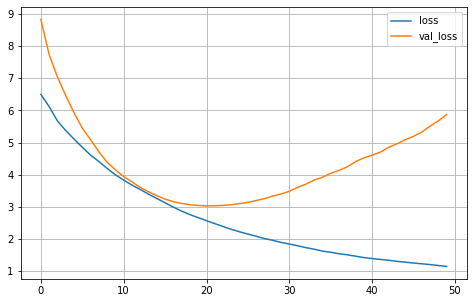

In [17]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

Claramente será mejor simplemente dejar de entrenar en la época 20. Esto lo hacemos con el callback de EarlyStopping.

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train[:100], y_train[:100], epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Train on 100 samples, validate on 3870 samples
Epoch 1/50
100/100 [==============================] - 1s 12ms/sample - loss: 6.4994 - val_loss: 8.8315
Epoch 2/50
100/100 [==============================] - 0s 3ms/sample - loss: 6.1169 - val_loss: 7.7324
Epoch 3/50
100/100 [==============================] - 0s 3ms/sample - loss: 5.6729 - val_loss: 7.0400
Epoch 4/50
100/100 [==============================] - 0s 3ms/sample - loss: 5.3749 - val_loss: 6.4612
Epoch 5/50
100/100 [==============================] - 0s 3ms/sample - loss: 5.1087 - val_loss: 5.9315
Epoch 6/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.8533 - val_loss: 5.4494
Epoch 7/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.6092 - val_loss: 5.0897
Epoch 8/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.4117 - val_loss: 4.7139
Epoch 9/50
100/100 [==============================] - 0s 3ms/sample - loss: 4.1954 - val_loss: 4.3872
Epoch 10/50
100/100 [=============

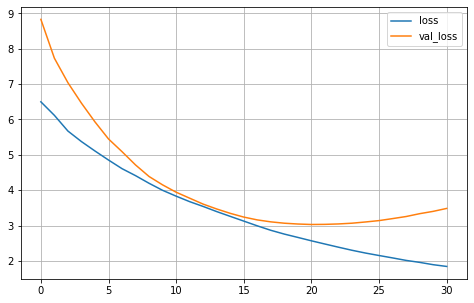

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

Vemos que paró en la época 31, porque pusimos una paciencia de 10 épocas (espera 10 épocas a ver si vuelve a mejorar, en caso que sea una fluctuación. Sin embargo, como pusimos `restore_best_weights=True`, el modelo fiteado debería corresponder al de la época 21:

In [31]:
model.evaluate(X_valid, y_valid, verbose=0)

3.0305901619815088

Que corresponde a la valid_loss en la época 21.